In [1]:
from ioMicro import *

In [ ]:
### check an image for segmentationm

In [143]:
fl = r'Z:\CGBB_embryo_4_28_2023\A1_LamA_Nup98_D16\Conv_zscan__059.zarr'#59
im2 = read_im(fl)
med_im0 = np.load(r'C:\Scripts\NMERFISH\Flat_field\Scope1_med_col_raw0.npz')['im']
med_im0 = cv2.blur(med_im0,(20,20))
med_im1 = np.load(r'C:\Scripts\NMERFISH\Flat_field\Scope1_med_col_raw1.npz')['im']
med_im1 = cv2.blur(med_im1,(20,20))
med_imnuc = np.load(r'C:\Scripts\NMERFISH\Flat_field\Scope1_med_col_raw3.npz')['im']
med_imnuc = cv2.blur(med_imnuc,(20,20))

im0 = np.array(im2[0],dtype=np.float32)[1:]
im1 = np.array(im2[1],dtype=np.float32)[1:]
imnuc = np.array(im2[-1],dtype=np.float32)
im0 =im0/med_im0*np.median(med_im0)
im1 = im1/med_im1*np.median(med_im1)
imnuc = imnuc/med_imnuc*np.median(med_imnuc)

In [67]:
#napari.view_image(imnuc)

In [144]:
psf = np.load(r'C:/Scripts/NMERFISH/psfs/psf_750_Scope1_embryo_big_final.npy')
imnucd = full_deconv(imnuc,s_=500,pad=100,psf=psf,parameters={'method': 'wiener', 'beta': 0.1},gpu=True,force=False)
im1d = full_deconv(im1,s_=500,pad=100,psf=psf,parameters={'method': 'wiener', 'beta': 0.1},gpu=True,force=False)
         

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00, 10.71it/s]


In [145]:
#img = norm_slice(im1[[15]],s=50)[:,::2,::2].copy()
V = napari.Viewer()#view_image(im1)
V.add_image(im1d,contrast_limits=[0,np.percentile(im1d[::5,::5,::5],99)])
V.add_image(imnucd,contrast_limits=[0,np.percentile(imnucd[::5,::5,::5],99)])

<Image layer 'imnucd' at 0x2891328d5e0>

In [116]:
#img = np.clip((norm_slice(im1d[[15]],s=100)-vmin)/(vmax-vmin),0,1)[:,::2,::2]
#np.percentile(norm_slice(im1d[[15]],s=100),99)

In [141]:
im1d.shape

(29, 2900, 2900)

In [142]:
#np.percentile(imnucd,1)
vmin = 5000
vmax=39000
imgnuc = np.clip((imnucd[[28]]-vmin)/(vmax-vmin),0,1)[:,::2,::2]
#napari.view_image(imgnuc)
#np.percentile(im1d[::5,::5,::5],99)
vmax=750
vmin=-500
imglam = np.clip((norm_slice(im1d[[28]],s=100)-vmin)/(vmax-vmin),0,1)[:,::2,::2]

img = np.array([imglam,imgnuc,imglam])
#np.swapaxes(img,-2).shape
img = np.swapaxes(np.swapaxes(np.swapaxes(img,0,-1),0,1),1,2)
napari.view_image(img)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 724.5, 724.5), zoom=0.8038965517241379, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 1.0, 1.0), (0.0, 1450.0, 1.0), (0.0, 1450.0, 1.0)), current_step=(0, 725, 725), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'img' at 0x2890a6dcb50>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_ve

In [131]:


from cellpose import models, io,utils
from scipy import ndimage
#changed cyto to CPx
model = models.Cellpose(gpu=True, model_type='cyto2')
masks, flows, styles, diams = model.eval(img,z_axis=0, diameter=35, channels=[3,2],
                                         flow_threshold=-10,cellprob_threshold=-10,normalize=False,
                                         do_3D=False,stitch_threshold=0.,
                                         progress=True)

In [132]:
V = napari.view_image(img)
V.add_labels(masks)

<Labels layer 'masks' at 0x287ede36c40>

### Start segmentation automatic here

In [1]:
def standard_segmentation_cyto2(fl,psf_file = r'C:/Scripts/NMERFISH/psfs/psf_750_Scope1_embryo_big_final.npy',save_folder=r'X:\\',plt_val=False,redo=False):
    segm_folder = save_folder+os.sep+'SegmentationCyto2'
    if not os.path.exists(segm_folder): os.makedirs(segm_folder)
    fl_dapi = fl
    save_fl  = segm_folder+os.sep+os.path.basename(fl_dapi).split('.')[0]+'--'+os.path.basename(os.path.dirname(fl_dapi))+'--dapi_segm.npz'
    if redo or (not os.path.exists(save_fl)):
        im2 = read_im(fl)
        #nup and lamin image
        #med_im0 = np.load(r'C:\Scripts\NMERFISH\Flat_field\Scope1_med_col_raw0.npz')['im']
        #med_im0 = cv2.blur(med_im0,(20,20))
        med_im1 = np.load(r'C:\Scripts\NMERFISH\Flat_field\Scope1_med_col_raw1.npz')['im']
        med_im1 = cv2.blur(med_im1,(20,20))
        
        med_imnuc = np.load(r'C:\Scripts\NMERFISH\Flat_field\Scope1_med_col_raw3.npz')['im']
        med_imnuc = cv2.blur(med_imnuc,(20,20))
        
        #im0 = np.array(im2[0],dtype=np.float32)[1:]
        #im0 =im0/med_im0*np.median(med_im0)
        
        im1 = np.array(im2[1],dtype=np.float32)[1:]
        imnuc = np.array(im2[-1],dtype=np.float32)
        
        im1 = im1/med_im1*np.median(med_im1)
        imnuc = imnuc/med_imnuc*np.median(med_imnuc)
        
        psf = np.load(psf_file)

        imnucd = full_deconv(imnuc,s_=500,pad=100,psf=psf,parameters={'method': 'wiener', 'beta': 0.1},gpu=True,force=False)
        im1d = full_deconv(im1,s_=500,pad=100,psf=psf,parameters={'method': 'wiener', 'beta': 0.1},gpu=True,force=False)


        vmin = 5000
        vmax=39000
        imgnuc = np.clip((imnucd[::2]-vmin)/(vmax-vmin),0,1)[:,::2,::2]
        #napari.view_image(imgnuc)
        #np.percentile(im1d[::5,::5,::5],99)
        vmax=750
        vmin=-500
        imglam = np.clip((norm_slice(im1d[::2],s=100)-vmin)/(vmax-vmin),0,1)[:,::2,::2]
        mlen = np.min([len(imglam),len(imgnuc)])
        img = np.array([imglam[:mlen],imgnuc[:mlen],imglam[:mlen]])
        #np.swapaxes(img,-2).shape
        img = np.swapaxes(np.swapaxes(np.swapaxes(img,0,-1),0,1),1,2)
        #napari.view_image(img)
        

        from cellpose import models, io,utils
        from scipy import ndimage
        #changed cyto to CPx
        model = models.Cellpose(gpu=True, model_type='cyto2')
        masks, flows, styles, diams = model.eval(img,z_axis=0, diameter=35, channels=[3,2],
                                                 flow_threshold=-10,cellprob_threshold=-10,normalize=False,
                                                 do_3D=False,stitch_threshold=0.5,
                                                 progress=True)
        shape = np.array(im1.shape)
        np.savez_compressed(save_fl,segm = masks,shape = shape)
        

In [1]:
from ioMicro import *
fl = r'Z:\CGBB_embryo_4_28_2023\A1_LamA_Nup98_D16\Conv_zscan__059.zarr'#59

In [3]:
standard_segmentation_cyto2(fl,psf_file = r'C:/Scripts/NMERFISH/psfs/psf_750_Scope1_embryo_big_final.npy',save_folder=r'X:\\',plt_val=False,redo=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.15it/s]


In [3]:
fls = glob.glob(r'Z:\CGBB_embryo_4_28_2023\A1_LamA_Nup98*\*.zarr')
fls=np.sort(fls)

In [ ]:
for fl in tqdm(fls):
    standard_segmentation_cyto2(fl,psf_file = r'C:/Scripts/NMERFISH/psfs/psf_750_Scope1_embryo_big_final.npy',save_folder=r'X:\\',plt_val=False,redo=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:05<00:00,  6.81it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.15it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.04it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.17it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:03<00:00,  9.01it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.84it/s]

100%|██████████████████████████████████████████████████████████████████████████████████| 36/36 [00:04<00:00,  8.87it/s]

100%|███████████████████████████

### Get segmentation file positions

In [2]:
from ioMicro import *

In [3]:
set_ = '_D16'
segm_fls = np.sort(glob.glob(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2'+os.sep+'*'+set_+'--dapi_segm.npz'))
#segm_fls
def get_pos_segms(segm_fls):
    xys = []
    for segm_fl in tqdm(segm_fls):
        fov,tag,_ = os.path.basename(segm_fl).split('--')
        set_ = tag.split('_')[-1]
        raw_fl = r'\\192.168.0.6\bbfishjoy4\CGBB_embryo_4_28_2023\H1_MER_'+set_+os.sep+fov+'.zarr'
        xy = get_pos(raw_fl)
        xys.append(xy)
    return np.array(xys)
    
pos0 = get_pos_segms(segm_fls)
pix_size = 0.1083333*2
np.save(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs--'+set_+'.npz',pos=pos0,fls=segm_fls)

100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [00:03<00:00, 66.76it/s]


### Stitch mosaic of cell segmentation

In [1]:
from ioMicro import *
dic_ = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs--'+set_+'.npz')
segm_fls,pos0 = dic_['fls'],dic_['pos']
resc = 2
pix_size = 0.1083333*resc

In [2]:
def get_drift_edge(iseg,icompfov):
    expected_drift = (pos_pix[iseg]-pos_pix[icompfov])*resc
    fl,fl_ref = segm_fls[iseg],segm_fls[icompfov]
    def get_fov_tag_set(fl):
        fov,tag,_ = os.path.basename(fl).split('--')
        set_ = '_'+tag.split('_')[-1]
        return fov,tag,set_
    fov,tag,set_ = get_fov_tag_set(fl)
    fov_ref,tag,set_ = get_fov_tag_set(fl_ref)
    dapi_fld = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets'+os.sep
    fl1=dapi_fld+fov+r'--'+tag+'--'+set_+'dapiFeatures.npz'
    fl2=dapi_fld+fov_ref+r'--'+tag+'--'+set_+'dapiFeatures.npz'
    #fl2=dapi_fld+r'Conv_zscan__059--A1_LamA_Nup98_D16--_D16dapiFeatures.npz'
    X,X_ref = np.load(fl1)['Xh_plus'][:,:3],np.load(fl2)['Xh_plus'][:,:3]
    resc_im = 5
    im,Xm = get_im_from_Xh(X,resc=resc_im)
    im_ref,Xm_ref = get_im_from_Xh(X_ref,resc=resc_im)
    
    from scipy.signal import fftconvolve
    im_cor = fftconvolve(im,im_ref[::-1,::-1,::-1])
    im_cor[:,50:-50,50:-50]=0
    #plt.imshow(np.max(im_cor,0))

    tzxy = np.array(np.unravel_index(np.argmax(im_cor),im_cor.shape))-im_ref.shape+1+Xm-Xm_ref
    tzxy = tzxy*resc_im
    
    Npts=0
    tzxy,Npts = get_Xtzxy(X,X_ref,tzxy,resc=resc_im,learn=1)

    tzxy_com = tzxy+([0]+list(expected_drift))
    if np.max(np.abs(tzxy_com))>100:
        return [0,0,0]
    final_tX = np.round(tzxy_com/resc).astype(int)
    
    return final_tX

In [3]:
pos = pos0[:,::-1]*[1,-1]
pos_pix = np.round(pos/pix_size).astype(int)
pos_pix = pos_pix-np.min(pos_pix,axis=0)
segm_fl = segm_fls[0]
dic = np.load(segm_fl)
im_segm = dic['segm']
pad=500
full_shape = [im_segm.shape[0]]+list(np.max(pos_pix,axis=0)+1+im_segm.shape[1:]+pad*2)
imfsegm = np.zeros(full_shape,dtype=np.int32)
imfovs = np.zeros(full_shape,dtype=np.int32)-1
coordsf = []
for iseg,segm_fl in enumerate(tqdm(segm_fls)):
    xm,ym = pos_pix[iseg]
    dic = np.load(segm_fl)
    im_segm = dic['segm'].astype(np.int32)
    ifov = int(os.path.basename(segm_fl).split('--')[0].split('_')[-1])
    im_segm[im_segm>0]+=ifov*10**5
    zsz,xsz,ysz = im_segm.shape
    
    imo = imfovs[:,pad+xm:pad+xm+xsz,pad+ym:pad+ym+ysz]
    npix = np.sum(imo>=0)
    #Xpos = np.array(np.where(imo>=0)).T
    txyz = [0,0,0]
    if npix:
        icomps,ncts_fovs = np.unique(imo,return_counts=True)
        ncts_fovs = ncts_fovs[icomps>=0]
        icomps=icomps[icomps>=0]
        icompfov = icomps[np.argmax(ncts_fovs)]###### which fov should you compare iseg
        txyz = get_drift_edge(iseg,icompfov)
        print(txyz)
        #zm_,xm_,ym_=np.min(Xpos,axis=0)
        #zM_,xM_,yM_=np.max(Xpos,axis=0)
        #txyz = get_txyz_small(imo[zm_:zM_,xm_:xM_,ym_:yM_]>0,im_segm[zm_:zM_,xm_:xM_,ym_:yM_]>0,sz_norm=0)
        #txyz = -np.array(txyz)
        if False:
            imo= imfsegm[:,pad-txyz[1]+xm:pad-txyz[1]+xm+xsz,pad-txyz[2]+ym:pad-txyz[2]+ym+ysz]
            resc__ = 3
            imo_ = imo[::1,::resc__,::resc__]
            im_segm_ = im_segm[::1,::resc__,::resc__]
            cellso,volso = np.unique(imo_,return_counts=True)
            volso,cellso = volso[cellso>0],cellso[cellso>0]
            dic_volsO = dict(zip(cellso,volso))
            cells,vols = np.unique(im_segm_,return_counts=True)
            vols,cells = vols[cells>0],cells[cells>0]
            dic_vols = dict(zip(cells,vols))
            Xo = np.array(nd.center_of_mass(imo_>0,imo_,cellso)).astype(int)
            cells_con = im_segm_[tuple(Xo.T)]
            cells_conO = cellso[cells_con>0]
            cells_con = cells_con[cells_con>0]
            for cello,cell in zip(cells_conO,cells_con):
                if dic_volsO[cello]>dic_vols[cell]:
                    im_segm[im_segm==cell]=cello
                else:
                    imT = imfsegm[:,pad-pad//2-txyz[1]+xm:pad+pad//2-txyz[1]+xm+xsz,pad-pad//2-txyz[2]+ym:pad+pad//2-txyz[2]+ym+ysz]
                    imT[imT==cello]=cell
                    imfsegm[:,pad-pad//2-txyz[1]+xm:pad+pad//2-txyz[1]+xm+xsz,pad-pad//2-txyz[2]+ym:pad+pad//2-txyz[2]+ym+ysz] = imT
    imfsegm[:,pad-txyz[1]+xm:pad-txyz[1]+xm+xsz,pad-txyz[2]+ym:pad-txyz[2]+ym+ysz]=im_segm
    imfovs[:,pad-txyz[1]+xm:pad-txyz[1]+xm+xsz,pad-txyz[2]+ym:pad-txyz[2]+ym+ysz]=iseg
    coordsf.append([pad-txyz[1]+xm,pad-txyz[1]+xm+xsz,pad-txyz[2]+ym,pad-txyz[2]+ym+ysz])

  1%|▋                                                                                 | 2/259 [00:01<03:53,  1.10it/s]

[ -2 -12  -7]


  1%|▉                                                                                 | 3/259 [00:02<04:35,  1.07s/it]

[ -3 -15  -8]


  2%|█▎                                                                                | 4/259 [00:04<04:56,  1.16s/it]

[-1 -8  4]


  2%|█▌                                                                                | 5/259 [00:05<05:07,  1.21s/it]

[0, 0, 0]


  3%|██▏                                                                               | 7/259 [00:07<04:22,  1.04s/it]

[ -2 -10  -6]


  3%|██▌                                                                               | 8/259 [00:08<04:42,  1.13s/it]

[  2   8 -15]


  3%|██▊                                                                               | 9/259 [00:09<04:53,  1.17s/it]

[ -2 -15  -9]


  4%|███▏                                                                             | 10/259 [00:11<05:01,  1.21s/it]

[  2   7 -13]


  4%|███▍                                                                             | 11/259 [00:12<05:06,  1.24s/it]

[0, 0, 0]


  5%|███▊                                                                             | 12/259 [00:13<05:07,  1.25s/it]

[-2 -9 -4]


  5%|████                                                                             | 13/259 [00:14<05:07,  1.25s/it]

[ -2 -10  -6]


  5%|████▍                                                                            | 14/259 [00:16<05:05,  1.25s/it]

[ -2 -15  -9]


  6%|████▋                                                                            | 15/259 [00:17<05:04,  1.25s/it]

[ -3 -11  -9]


  6%|█████                                                                            | 16/259 [00:18<05:07,  1.27s/it]

[ -3 -11 -10]


  7%|█████▎                                                                           | 17/259 [00:19<05:07,  1.27s/it]

[ -2 -14  -8]


  7%|█████▋                                                                           | 18/259 [00:21<05:06,  1.27s/it]

[  3   8 -12]


  7%|█████▉                                                                           | 19/259 [00:22<05:05,  1.27s/it]

[ -3 -15  -8]


  8%|██████▎                                                                          | 20/259 [00:23<05:00,  1.26s/it]

[ 0 43 -5]


  8%|██████▌                                                                          | 21/259 [00:24<04:59,  1.26s/it]

[0, 0, 0]


  8%|██████▉                                                                          | 22/259 [00:26<05:02,  1.28s/it]

[ -2 -16  -7]


  9%|███████▏                                                                         | 23/259 [00:27<05:05,  1.29s/it]

[-2 -7 14]


  9%|███████▌                                                                         | 24/259 [00:28<05:06,  1.31s/it]

[ 3 13 10]


 10%|███████▊                                                                         | 25/259 [00:30<05:06,  1.31s/it]

[ 2 12  8]


 10%|████████▏                                                                        | 26/259 [00:31<05:07,  1.32s/it]

[ 2 15  7]


 10%|████████▍                                                                        | 27/259 [00:32<05:06,  1.32s/it]

[0, 0, 0]


 11%|████████▊                                                                        | 28/259 [00:34<04:58,  1.29s/it]

[0, 0, 0]


 11%|█████████                                                                        | 29/259 [00:35<04:59,  1.30s/it]

[-3 -9 17]


 12%|█████████▍                                                                       | 30/259 [00:36<05:05,  1.34s/it]

[ -2 -10  18]


 12%|█████████▋                                                                       | 31/259 [00:38<05:14,  1.38s/it]

[ -2 -18  -4]


 12%|██████████                                                                       | 32/259 [00:39<05:08,  1.36s/it]

[-2 -5 -6]


 13%|██████████▎                                                                      | 33/259 [00:40<05:02,  1.34s/it]

[ -3  -2 -10]


 13%|██████████▋                                                                      | 34/259 [00:42<04:57,  1.32s/it]

[ -3 -18  -7]


 14%|██████████▉                                                                      | 35/259 [00:43<04:51,  1.30s/it]

[0, 0, 0]


 14%|███████████▎                                                                     | 36/259 [00:44<04:46,  1.29s/it]

[ 3  9 10]


 14%|███████████▌                                                                     | 37/259 [00:46<04:45,  1.29s/it]

[ 3 18  8]


 15%|███████████▉                                                                     | 38/259 [00:47<04:45,  1.29s/it]

[2 5 8]


 15%|████████████▏                                                                    | 39/259 [00:48<04:44,  1.29s/it]

[0, 0, 0]


 15%|████████████▌                                                                    | 40/259 [00:49<04:44,  1.30s/it]

[-2 -9 14]


 16%|████████████▊                                                                    | 41/259 [00:51<04:41,  1.29s/it]

[-2 -8 12]


 16%|█████████████▏                                                                   | 42/259 [00:52<04:36,  1.27s/it]

[-2 -9 15]


 17%|█████████████▍                                                                   | 43/259 [00:53<04:34,  1.27s/it]

[-2 -7  9]


 17%|█████████████▊                                                                   | 44/259 [00:55<04:33,  1.27s/it]

[ 3 11  9]


 17%|██████████████                                                                   | 45/259 [00:56<04:33,  1.28s/it]

[-2 -7 14]


 18%|██████████████▍                                                                  | 46/259 [00:57<04:32,  1.28s/it]

[ -4 -15  13]


 18%|██████████████▋                                                                  | 47/259 [00:58<04:29,  1.27s/it]

[0, 0, 0]


 19%|███████████████                                                                  | 48/259 [01:00<04:28,  1.27s/it]

[-2 -9 16]


 19%|███████████████▎                                                                 | 49/259 [01:01<04:27,  1.27s/it]

[ 2 11  8]


 19%|███████████████▋                                                                 | 50/259 [01:02<04:23,  1.26s/it]

[-1 -8 19]


 20%|███████████████▉                                                                 | 51/259 [01:04<04:30,  1.30s/it]

[1 6 8]


 20%|████████████████▎                                                                | 52/259 [01:05<04:26,  1.29s/it]

[-2 -8 15]


 20%|████████████████▌                                                                | 53/259 [01:06<04:25,  1.29s/it]

[-2 -9 13]


 21%|████████████████▉                                                                | 54/259 [01:07<04:24,  1.29s/it]

[-3 -9 17]


 21%|█████████████████▏                                                               | 55/259 [01:09<04:20,  1.27s/it]

[ -3 -12  -8]


 22%|█████████████████▌                                                               | 56/259 [01:10<04:17,  1.27s/it]

[-3 -9 21]


 22%|█████████████████▊                                                               | 57/259 [01:11<04:16,  1.27s/it]

[ -2 -12  -8]


 22%|██████████████████▏                                                              | 58/259 [01:12<04:15,  1.27s/it]

[ -2 -13  -9]


 23%|██████████████████▍                                                              | 59/259 [01:14<04:10,  1.25s/it]

[ -3 -16  -8]


 23%|██████████████████▊                                                              | 60/259 [01:15<04:07,  1.24s/it]

[  2   8 -21]


 24%|███████████████████                                                              | 61/259 [01:16<04:07,  1.25s/it]

[ -3 -15  -6]


 24%|███████████████████▍                                                             | 62/259 [01:17<04:06,  1.25s/it]

[  2   8 -13]


 24%|███████████████████▋                                                             | 63/259 [01:19<04:04,  1.25s/it]

[ -2 -14  -8]


 25%|████████████████████                                                             | 64/259 [01:20<04:01,  1.24s/it]

[  2   8 -12]


 25%|████████████████████▎                                                            | 65/259 [01:21<04:03,  1.25s/it]

[ -3 -16  -9]


 25%|████████████████████▋                                                            | 66/259 [01:22<04:02,  1.26s/it]

[  2   8 -10]


 26%|████████████████████▉                                                            | 67/259 [01:24<04:01,  1.26s/it]

[-2 -2 -9]


 26%|█████████████████████▎                                                           | 68/259 [01:25<04:01,  1.27s/it]

[  2   8 -12]


 27%|█████████████████████▌                                                           | 69/259 [01:26<04:00,  1.27s/it]

[ -3 -14  16]


 27%|█████████████████████▉                                                           | 70/259 [01:27<04:00,  1.27s/it]

[-2 -7 10]


 27%|██████████████████████▏                                                          | 71/259 [01:29<03:59,  1.27s/it]

[ -2  -6 -10]


 28%|██████████████████████▌                                                          | 72/259 [01:30<03:57,  1.27s/it]

[ -3 -17 -10]


 28%|██████████████████████▊                                                          | 73/259 [01:31<03:55,  1.27s/it]

[  2   9 -18]


 29%|███████████████████████▏                                                         | 74/259 [01:32<03:51,  1.25s/it]

[0, 0, 0]


 29%|███████████████████████▍                                                         | 75/259 [01:34<03:49,  1.25s/it]

[  3   8 -15]


 29%|███████████████████████▊                                                         | 76/259 [01:35<03:48,  1.25s/it]

[-3 -3 -8]


 30%|████████████████████████                                                         | 77/259 [01:36<03:47,  1.25s/it]

[-3 -3 -6]


 30%|████████████████████████▍                                                        | 78/259 [01:37<03:44,  1.24s/it]

[0, 0, 0]


 31%|████████████████████████▋                                                        | 79/259 [01:39<03:44,  1.25s/it]

[ -2 -10  13]


 31%|█████████████████████████                                                        | 80/259 [01:40<03:45,  1.26s/it]

[ -3 -11  -9]


 31%|█████████████████████████▎                                                       | 81/259 [01:41<03:44,  1.26s/it]

[ 2  7 -9]


 32%|█████████████████████████▋                                                       | 82/259 [01:43<03:44,  1.27s/it]

[  3   9 -13]


 32%|█████████████████████████▉                                                       | 83/259 [01:44<03:44,  1.28s/it]

[ -3 -14 -10]


 32%|██████████████████████████▎                                                      | 84/259 [01:45<03:43,  1.28s/it]

[ -3 -15 -10]


 33%|██████████████████████████▌                                                      | 85/259 [01:46<03:42,  1.28s/it]

[0, 0, 0]


 33%|██████████████████████████▉                                                      | 86/259 [01:48<03:41,  1.28s/it]

[-2 -7 14]


 34%|███████████████████████████▏                                                     | 87/259 [01:49<03:42,  1.29s/it]

[ 3 11  9]


 34%|███████████████████████████▌                                                     | 88/259 [01:50<03:39,  1.28s/it]

[0, 0, 0]


 34%|███████████████████████████▊                                                     | 89/259 [01:52<03:39,  1.29s/it]

[-2 -7 12]


 35%|████████████████████████████▏                                                    | 90/259 [01:53<03:36,  1.28s/it]

[ -3 -18  -8]


 35%|████████████████████████████▍                                                    | 91/259 [01:54<03:35,  1.28s/it]

[-2 -7 16]


 36%|████████████████████████████▊                                                    | 92/259 [01:55<03:32,  1.27s/it]

[-2 -5 -7]


 36%|█████████████████████████████                                                    | 93/259 [01:57<03:29,  1.26s/it]

[-1 -6 19]


 36%|█████████████████████████████▍                                                   | 94/259 [01:58<03:26,  1.25s/it]

[0, 0, 0]


 37%|█████████████████████████████▋                                                   | 95/259 [01:59<03:25,  1.25s/it]

[-2 -8 13]


 37%|██████████████████████████████                                                   | 96/259 [02:00<03:23,  1.25s/it]

[0, 0, 0]


 37%|██████████████████████████████▎                                                  | 97/259 [02:02<03:22,  1.25s/it]

[  2   8 -12]


 38%|██████████████████████████████▋                                                  | 98/259 [02:03<03:19,  1.24s/it]

[  2   8 -15]


 38%|██████████████████████████████▉                                                  | 99/259 [02:04<03:21,  1.26s/it]

[ -2 -11  -8]


 39%|██████████████████████████████▉                                                 | 100/259 [02:05<03:21,  1.27s/it]

[0, 0, 0]


 39%|███████████████████████████████▏                                                | 101/259 [02:07<03:21,  1.28s/it]

[ -3 -10  18]


 39%|███████████████████████████████▌                                                | 102/259 [02:08<03:22,  1.29s/it]

[-2 -8 14]


 40%|███████████████████████████████▊                                                | 103/259 [02:09<03:21,  1.29s/it]

[-2 -8 16]


 40%|████████████████████████████████                                                | 104/259 [02:11<03:19,  1.29s/it]

[-2 -9 19]


 41%|████████████████████████████████▍                                               | 105/259 [02:12<03:17,  1.28s/it]

[-3 -8 18]


 41%|████████████████████████████████▋                                               | 106/259 [02:13<03:16,  1.28s/it]

[-2 -8 14]


 41%|█████████████████████████████████                                               | 107/259 [02:14<03:15,  1.28s/it]

[ -2 -10  15]


 42%|█████████████████████████████████▎                                              | 108/259 [02:16<03:12,  1.28s/it]

[ 3 14  8]


 42%|█████████████████████████████████▋                                              | 109/259 [02:17<03:10,  1.27s/it]

[-2 -6 13]


 42%|█████████████████████████████████▉                                              | 110/259 [02:18<03:09,  1.27s/it]

[-2 -7 12]


 43%|██████████████████████████████████▎                                             | 111/259 [02:20<03:09,  1.28s/it]

[-3 -8 13]


 43%|██████████████████████████████████▌                                             | 112/259 [02:21<03:08,  1.28s/it]

[-2 -7 14]


 44%|██████████████████████████████████▉                                             | 113/259 [02:22<03:08,  1.29s/it]

[ -2 -10  13]


 44%|███████████████████████████████████▏                                            | 114/259 [02:23<03:04,  1.27s/it]

[ -3 -10  15]


 44%|███████████████████████████████████▌                                            | 115/259 [02:25<03:03,  1.27s/it]

[ -3 -11  14]


 45%|███████████████████████████████████▊                                            | 116/259 [02:26<03:01,  1.27s/it]

[-2 -7 13]


 45%|████████████████████████████████████▏                                           | 117/259 [02:27<02:59,  1.26s/it]

[ 3 14  8]


 46%|████████████████████████████████████▍                                           | 118/259 [02:28<02:58,  1.27s/it]

[-2 -5 14]


 46%|████████████████████████████████████▊                                           | 119/259 [02:30<02:56,  1.26s/it]

[2 2 8]


 46%|█████████████████████████████████████                                           | 120/259 [02:31<02:56,  1.27s/it]

[-2 -7  9]


 47%|█████████████████████████████████████▎                                          | 121/259 [02:32<02:55,  1.27s/it]

[0, 0, 0]


 47%|█████████████████████████████████████▉                                          | 123/259 [02:34<02:24,  1.06s/it]

[ -3 -17  -7]


 48%|██████████████████████████████████████▎                                         | 124/259 [02:35<02:32,  1.13s/it]

[ 3  8 -7]


 48%|██████████████████████████████████████▌                                         | 125/259 [02:36<02:37,  1.18s/it]

[-3 -4 -9]


 49%|██████████████████████████████████████▉                                         | 126/259 [02:38<02:41,  1.21s/it]

[ 2  8 -4]


 49%|███████████████████████████████████████▏                                        | 127/259 [02:39<02:40,  1.22s/it]

[-3 -9 14]


 49%|███████████████████████████████████████▌                                        | 128/259 [02:40<02:40,  1.23s/it]

[-2 -9 18]


 50%|███████████████████████████████████████▊                                        | 129/259 [02:41<02:41,  1.24s/it]

[0, 0, 0]


 50%|████████████████████████████████████████▏                                       | 130/259 [02:43<02:41,  1.25s/it]

[-3 -7 18]


 51%|████████████████████████████████████████▍                                       | 131/259 [02:44<02:42,  1.27s/it]

[-2 -8 13]


 51%|████████████████████████████████████████▊                                       | 132/259 [02:45<02:41,  1.27s/it]

[ -3 -12  -8]


 51%|█████████████████████████████████████████                                       | 133/259 [02:47<02:40,  1.28s/it]

[-2 -7  9]


 52%|█████████████████████████████████████████▍                                      | 134/259 [02:48<02:38,  1.27s/it]

[ -3 -10  10]


 52%|█████████████████████████████████████████▋                                      | 135/259 [02:49<02:39,  1.29s/it]

[-3 -7  3]


 53%|██████████████████████████████████████████                                      | 136/259 [02:50<02:38,  1.29s/it]

[  0  -2 -41]


 53%|██████████████████████████████████████████▎                                     | 137/259 [02:52<02:37,  1.29s/it]

[ -3 -13  -7]


 53%|██████████████████████████████████████████▋                                     | 138/259 [02:53<02:37,  1.30s/it]

[ -4 -14 -10]


 54%|██████████████████████████████████████████▉                                     | 139/259 [02:54<02:33,  1.28s/it]

[0, 0, 0]


 54%|███████████████████████████████████████████▏                                    | 140/259 [02:56<02:32,  1.28s/it]

[-2 -4 -9]


 54%|███████████████████████████████████████████▌                                    | 141/259 [02:57<02:28,  1.26s/it]

[0, 0, 0]


 55%|███████████████████████████████████████████▊                                    | 142/259 [02:58<02:23,  1.23s/it]

[0, 0, 0]


 55%|████████████████████████████████████████████▏                                   | 143/259 [02:59<02:23,  1.24s/it]

[-3  8  3]


 56%|████████████████████████████████████████████▍                                   | 144/259 [03:00<02:22,  1.24s/it]

[ 3  4 12]


 56%|████████████████████████████████████████████▊                                   | 145/259 [03:02<02:21,  1.24s/it]

[3 7 9]


 56%|█████████████████████████████████████████████                                   | 146/259 [03:03<02:20,  1.24s/it]

[ 3  8 -9]


 57%|█████████████████████████████████████████████▍                                  | 147/259 [03:04<02:19,  1.24s/it]

[ 2 14  8]


 57%|█████████████████████████████████████████████▋                                  | 148/259 [03:05<02:16,  1.23s/it]

[ 2  8 -7]


 58%|██████████████████████████████████████████████                                  | 149/259 [03:07<02:22,  1.29s/it]

[ 3 19  8]


 58%|██████████████████████████████████████████████▎                                 | 150/259 [03:08<02:22,  1.30s/it]

[ 3 17 15]


 58%|██████████████████████████████████████████████▋                                 | 151/259 [03:09<02:20,  1.30s/it]

[ 2 17 14]


 59%|██████████████████████████████████████████████▉                                 | 152/259 [03:11<02:18,  1.29s/it]

[ 3 16  5]


 59%|███████████████████████████████████████████████▎                                | 153/259 [03:12<02:17,  1.30s/it]

[  3   8 -10]


 59%|███████████████████████████████████████████████▌                                | 154/259 [03:13<02:14,  1.28s/it]

[ 3 12  8]


 60%|███████████████████████████████████████████████▉                                | 155/259 [03:14<02:11,  1.27s/it]

[1 8 8]


 60%|████████████████████████████████████████████████▏                               | 156/259 [03:16<02:09,  1.26s/it]

[ 1  8 -6]


 61%|████████████████████████████████████████████████▍                               | 157/259 [03:17<02:09,  1.27s/it]

[ 0 11 11]


 61%|████████████████████████████████████████████████▊                               | 158/259 [03:18<02:07,  1.27s/it]

[ 1  8 -4]


 61%|█████████████████████████████████████████████████                               | 159/259 [03:19<02:05,  1.26s/it]

[ 2 12 12]


 62%|█████████████████████████████████████████████████▍                              | 160/259 [03:21<02:05,  1.26s/it]

[ 3  8 -5]


 62%|█████████████████████████████████████████████████▋                              | 161/259 [03:22<02:04,  1.27s/it]

[ 3 14 11]


 63%|██████████████████████████████████████████████████                              | 162/259 [03:23<02:07,  1.31s/it]

[  2   8 -11]


 63%|██████████████████████████████████████████████████▎                             | 163/259 [03:25<02:06,  1.32s/it]

[ 2 18 14]


 63%|██████████████████████████████████████████████████▋                             | 164/259 [03:26<02:03,  1.30s/it]

[  3   8 -15]


 64%|██████████████████████████████████████████████████▉                             | 165/259 [03:27<02:01,  1.29s/it]

[ 3  7 15]


 64%|███████████████████████████████████████████████████▎                            | 166/259 [03:29<01:59,  1.29s/it]

[  2   7 -13]


 64%|███████████████████████████████████████████████████▌                            | 167/259 [03:30<01:58,  1.29s/it]

[-2 -8 22]


 65%|███████████████████████████████████████████████████▉                            | 168/259 [03:31<01:56,  1.28s/it]

[  3   9 -13]


 65%|████████████████████████████████████████████████████▏                           | 169/259 [03:32<01:55,  1.28s/it]

[  2   8 -13]


 66%|████████████████████████████████████████████████████▌                           | 170/259 [03:34<01:52,  1.27s/it]

[  2   9 -14]


 66%|████████████████████████████████████████████████████▊                           | 171/259 [03:35<01:52,  1.27s/it]

[ -3 -14  -1]


 66%|█████████████████████████████████████████████████████▏                          | 172/259 [03:36<01:50,  1.27s/it]

[ 3 19  6]


 67%|█████████████████████████████████████████████████████▍                          | 173/259 [03:37<01:49,  1.27s/it]

[  2  10 -15]


 67%|█████████████████████████████████████████████████████▋                          | 174/259 [03:39<01:48,  1.27s/it]

[ 3 14  9]


 68%|██████████████████████████████████████████████████████                          | 175/259 [03:40<01:46,  1.27s/it]

[-2 -8 12]


 68%|██████████████████████████████████████████████████████▎                         | 176/259 [03:41<01:44,  1.26s/it]

[-3 -8 13]


 68%|██████████████████████████████████████████████████████▋                         | 177/259 [03:43<01:43,  1.27s/it]

[ 2 11  8]


 69%|██████████████████████████████████████████████████████▉                         | 178/259 [03:44<01:42,  1.27s/it]

[  3   8 -13]


 69%|███████████████████████████████████████████████████████▎                        | 179/259 [03:45<01:41,  1.27s/it]

[  3   8 -13]


 69%|███████████████████████████████████████████████████████▌                        | 180/259 [03:46<01:41,  1.28s/it]

[-3 -7 19]


 70%|███████████████████████████████████████████████████████▉                        | 181/259 [03:48<01:39,  1.27s/it]

[-2 -8 12]


 70%|████████████████████████████████████████████████████████▏                       | 182/259 [03:49<01:38,  1.28s/it]

[-4 -8 20]


 71%|████████████████████████████████████████████████████████▌                       | 183/259 [03:50<01:36,  1.28s/it]

[-2 -8 13]


 71%|████████████████████████████████████████████████████████▊                       | 184/259 [03:51<01:35,  1.27s/it]

[-3 -8 15]


 71%|█████████████████████████████████████████████████████████▏                      | 185/259 [03:53<01:33,  1.27s/it]

[-3 -8 14]


 72%|█████████████████████████████████████████████████████████▍                      | 186/259 [03:54<01:32,  1.27s/it]

[-2 -8 15]


 72%|█████████████████████████████████████████████████████████▊                      | 187/259 [03:55<01:30,  1.26s/it]

[-2 -9 15]


 73%|██████████████████████████████████████████████████████████                      | 188/259 [03:57<01:29,  1.26s/it]

[-2 -8  9]


 73%|██████████████████████████████████████████████████████████▍                     | 189/259 [03:58<01:28,  1.26s/it]

[-2 -9 11]


 73%|██████████████████████████████████████████████████████████▋                     | 190/259 [03:59<01:27,  1.27s/it]

[ 2 15  8]


 74%|██████████████████████████████████████████████████████████▉                     | 191/259 [04:00<01:26,  1.27s/it]

[-3 -8  3]


 74%|███████████████████████████████████████████████████████████▎                    | 192/259 [04:02<01:25,  1.28s/it]

[0, 0, 0]


 75%|███████████████████████████████████████████████████████████▌                    | 193/259 [04:03<01:24,  1.28s/it]

[-2 -8  6]


 75%|███████████████████████████████████████████████████████████▉                    | 194/259 [04:04<01:22,  1.27s/it]

[ 3 12 10]


 75%|████████████████████████████████████████████████████████████▏                   | 195/259 [04:05<01:21,  1.27s/it]

[  0   8 -11]


 76%|████████████████████████████████████████████████████████████▌                   | 196/259 [04:07<01:20,  1.28s/it]

[  1 -11  -8]


 76%|████████████████████████████████████████████████████████████▊                   | 197/259 [04:08<01:19,  1.28s/it]

[  2   8 -14]


 76%|█████████████████████████████████████████████████████████████▏                  | 198/259 [04:09<01:17,  1.27s/it]

[  3   8 -13]


 77%|█████████████████████████████████████████████████████████████▍                  | 199/259 [04:11<01:16,  1.27s/it]

[ 3 12  8]


 77%|█████████████████████████████████████████████████████████████▊                  | 200/259 [04:12<01:14,  1.27s/it]

[-2 -8 13]


 78%|██████████████████████████████████████████████████████████████                  | 201/259 [04:13<01:13,  1.27s/it]

[ 5 17  8]


 78%|██████████████████████████████████████████████████████████████▍                 | 202/259 [04:14<01:12,  1.27s/it]

[  3   7 -13]


 78%|██████████████████████████████████████████████████████████████▋                 | 203/259 [04:16<01:11,  1.27s/it]

[  3   9 -13]


 79%|███████████████████████████████████████████████████████████████                 | 204/259 [04:17<01:09,  1.27s/it]

[2 9 8]


 79%|███████████████████████████████████████████████████████████████▎                | 205/259 [04:18<01:08,  1.27s/it]

[  5   8 -13]


 80%|███████████████████████████████████████████████████████████████▋                | 206/259 [04:19<01:06,  1.26s/it]

[  4  10 -13]


 80%|███████████████████████████████████████████████████████████████▉                | 207/259 [04:21<01:05,  1.25s/it]

[ -2 -16  -8]


 80%|████████████████████████████████████████████████████████████████▏               | 208/259 [04:22<01:04,  1.26s/it]

[ -3 -12  -8]


 81%|████████████████████████████████████████████████████████████████▌               | 209/259 [04:23<01:03,  1.27s/it]

[  4   7 -14]


 81%|████████████████████████████████████████████████████████████████▊               | 210/259 [04:24<01:02,  1.27s/it]

[ 2 11  8]


 81%|█████████████████████████████████████████████████████████████████▏              | 211/259 [04:26<01:00,  1.26s/it]

[ 2 17  8]


 82%|█████████████████████████████████████████████████████████████████▍              | 212/259 [04:27<00:58,  1.25s/it]

[2 8 8]


 82%|█████████████████████████████████████████████████████████████████▊              | 213/259 [04:28<00:57,  1.25s/it]

[  3   8 -13]


 83%|██████████████████████████████████████████████████████████████████              | 214/259 [04:29<00:56,  1.25s/it]

[-3 -7 -8]


 83%|██████████████████████████████████████████████████████████████████▍             | 215/259 [04:31<00:55,  1.26s/it]

[ -2 -16  -8]


 83%|██████████████████████████████████████████████████████████████████▋             | 216/259 [04:32<00:53,  1.25s/it]

[ -3 -11  -8]


 84%|███████████████████████████████████████████████████████████████████             | 217/259 [04:33<00:52,  1.25s/it]

[  2   8 -19]


 84%|███████████████████████████████████████████████████████████████████▎            | 218/259 [04:34<00:51,  1.26s/it]

[ 4  9 20]


 85%|███████████████████████████████████████████████████████████████████▋            | 219/259 [04:36<00:50,  1.26s/it]

[  2   8 -16]


 85%|███████████████████████████████████████████████████████████████████▉            | 220/259 [04:37<00:49,  1.26s/it]

[-2 -6 -9]


 85%|████████████████████████████████████████████████████████████████████▎           | 221/259 [04:38<00:48,  1.27s/it]

[  2   8 -12]


 86%|████████████████████████████████████████████████████████████████████▌           | 222/259 [04:40<00:47,  1.27s/it]

[  2   9 -15]


 86%|████████████████████████████████████████████████████████████████████▉           | 223/259 [04:41<00:45,  1.26s/it]

[  3   8 -13]


 86%|█████████████████████████████████████████████████████████████████████▏          | 224/259 [04:42<00:43,  1.25s/it]

[  2   9 -15]


 87%|█████████████████████████████████████████████████████████████████████▍          | 225/259 [04:43<00:42,  1.26s/it]

[  2   8 -10]


 87%|█████████████████████████████████████████████████████████████████████▊          | 226/259 [04:45<00:41,  1.26s/it]

[ -2 -11  -9]


 88%|██████████████████████████████████████████████████████████████████████          | 227/259 [04:46<00:40,  1.26s/it]

[  2   8 -12]


 88%|██████████████████████████████████████████████████████████████████████▍         | 228/259 [04:47<00:39,  1.26s/it]

[ 2 12  7]


 88%|██████████████████████████████████████████████████████████████████████▋         | 229/259 [04:48<00:38,  1.27s/it]

[3 7 8]


 89%|███████████████████████████████████████████████████████████████████████         | 230/259 [04:50<00:37,  1.29s/it]

[0, 0, 0]


 89%|███████████████████████████████████████████████████████████████████████▎        | 231/259 [04:51<00:36,  1.29s/it]

[ -1 -23   5]


 90%|███████████████████████████████████████████████████████████████████████▋        | 232/259 [04:52<00:34,  1.30s/it]

[ 2 15  6]


 90%|███████████████████████████████████████████████████████████████████████▉        | 233/259 [04:54<00:33,  1.30s/it]

[  2   9 -15]


 90%|████████████████████████████████████████████████████████████████████████▎       | 234/259 [04:55<00:32,  1.30s/it]

[ 2 15  8]


 91%|████████████████████████████████████████████████████████████████████████▌       | 235/259 [04:56<00:31,  1.29s/it]

[-2 -8 10]


 91%|████████████████████████████████████████████████████████████████████████▉       | 236/259 [04:57<00:29,  1.29s/it]

[0, 0, 0]


 92%|█████████████████████████████████████████████████████████████████████████▏      | 237/259 [04:59<00:28,  1.28s/it]

[-2 -9 15]


 92%|█████████████████████████████████████████████████████████████████████████▌      | 238/259 [05:00<00:26,  1.27s/it]

[-2 -8 13]


 92%|█████████████████████████████████████████████████████████████████████████▊      | 239/259 [05:01<00:25,  1.27s/it]

[-2 -8 13]


 93%|██████████████████████████████████████████████████████████████████████████▏     | 240/259 [05:03<00:24,  1.26s/it]

[-2 -7 16]


 93%|██████████████████████████████████████████████████████████████████████████▍     | 241/259 [05:04<00:22,  1.27s/it]

[  2   8 -22]


 93%|██████████████████████████████████████████████████████████████████████████▋     | 242/259 [05:05<00:21,  1.27s/it]

[  1   8 -22]


 94%|███████████████████████████████████████████████████████████████████████████     | 243/259 [05:06<00:20,  1.28s/it]

[  4   8 -15]


 94%|███████████████████████████████████████████████████████████████████████████▎    | 244/259 [05:08<00:19,  1.28s/it]

[  1   8 -16]


 95%|███████████████████████████████████████████████████████████████████████████▋    | 245/259 [05:09<00:17,  1.28s/it]

[  2   8 -12]


 95%|███████████████████████████████████████████████████████████████████████████▉    | 246/259 [05:10<00:16,  1.28s/it]

[  3   9 -13]


 95%|████████████████████████████████████████████████████████████████████████████▎   | 247/259 [05:12<00:15,  1.29s/it]

[  0   9 -11]


 96%|████████████████████████████████████████████████████████████████████████████▌   | 248/259 [05:13<00:14,  1.29s/it]

[  2   8 -10]


 96%|████████████████████████████████████████████████████████████████████████████▉   | 249/259 [05:14<00:12,  1.28s/it]

[ 2 17  7]


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 250/259 [05:15<00:11,  1.28s/it]

[  2   8 -12]


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 251/259 [05:17<00:10,  1.28s/it]

[ 0 12 10]


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 252/259 [05:18<00:09,  1.29s/it]

[  2   9 -13]


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 253/259 [05:19<00:07,  1.29s/it]

[  2   7 -15]


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 254/259 [05:21<00:06,  1.32s/it]

[ 1  6 19]


 98%|██████████████████████████████████████████████████████████████████████████████▊ | 255/259 [05:22<00:05,  1.31s/it]

[ 3  5 21]


 99%|███████████████████████████████████████████████████████████████████████████████ | 256/259 [05:23<00:03,  1.30s/it]

[0, 0, 0]


 99%|███████████████████████████████████████████████████████████████████████████████▍| 257/259 [05:24<00:02,  1.29s/it]

[ -3 -10  -8]


100%|███████████████████████████████████████████████████████████████████████████████▋| 258/259 [05:26<00:01,  1.28s/it]

[0, 0, 0]


100%|████████████████████████████████████████████████████████████████████████████████| 259/259 [05:27<00:00,  1.26s/it]

[0, 0, 0]


In [5]:
np.savez_compressed(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\imfsegm.npz',
                    imfsegm=imfsegm,coordsf=coordsf,resc=[2,2,2])

In [4]:
import napari
napari.view_labels(imfsegm[::3,::3,::3])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 3606.0, 5205.0), zoom=0.1616040482462221, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=10, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 5.0, 1.0), (0.0, 7213.0, 1.0), (0.0, 10411.0, 1.0)), current_step=(2, 3606, 5205), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Labels layer 'Labels' at 0x26b7f5b4100>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10, unit=None), text_overlay=TextOverlay(visible=False, color=(0.5, 0.5, 0.5, 1.0), font_size=10, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, show_ver

### Pull together transcripts and assign to cells

In [ ]:
scoresRef=None

In [13]:
from ioMicro import *
save_folder =r'//192.168.0.7/bbfishmahsa3/CGBB_embryo_4_28_2023/MERFISH_AnalysisP56'
fov,set_ = 'Conv_zscan__040', '_D16'
dec = decoder_simple(save_folder,fov,set_)
dec.ncols=3
dec.load_decoded()

Loaded decoded: -20.97408151626587


True

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:21<00:00,  2.25it/s]


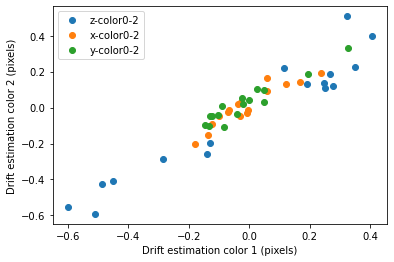

In [14]:
apply_fine_drift(dec,plt_val=True)

In [23]:
apply_flat_field(dec)

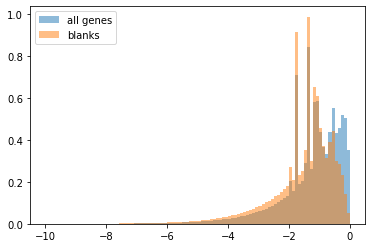

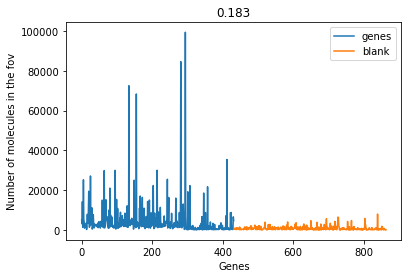

In [24]:
scoresRefT = get_score_per_color(dec)
get_score_withRef(dec,scoresRefT,plt_val=True,gene=None,iSs = None,th_min=-10)
dec.th=-0.5
plot_statistics(dec)

In [25]:
icds,ncds = np.unique(dec.icodesN[dec.scoreA>dec.th],return_counts=True)
print(list(np.array(dec.gns_names)[icds[np.argsort(ncds)[::-1]]]))

['Nfix', 'Sox4', 'Sox11', 'Neurod2', 'Smarca4', 'Ptprd', 'Rtn4', 'Psap', 'Ogt', 'Runx1t1', 'Nfib', 'Nefl', 'Sox5', 'Ppp2r2b', 'Nr4a2', 'Ptprz1', 'Rgma', 'Nrp1', 'Nnat', 'Ppp3ca', 'Nrep', 'Ntrk2', 'Scd2', 'Slc25a4', 'Satb2', 'Rangap1', 'Pfkm', 'Ppfia2', 'Ppm1l', 'Pde10a', 'Nefm', 'Sphkap', 'Snap25', 'Reep5', 'Opcml', 'Nptxr', 'Pam', 'Nfia', 'Scube1', 'Rfx3', 'Pde1a', 'Nr2f2', 'Nrg3', 'Satb1', 'Rab3c', 'Sirt2', 'Slc6a1', 'Ptbp2', 'St6galnac5', 'Srsf2', 'Plekha1', 'Prickle2', 'Slit3', 'Rac3', 'Sgcz', 'blank0407', 'Nrn1', 'Nptx1', 'Pbx1', 'Rgs12', 'Sncg', 'Slc17a7', 'Slc7a5', 'Rnasel', 'Nin', 'Pcdh19', 'Nrxn3', 'Plxna1', 'Rasgrp1', 'Stmn1', 'Rims4', 'blank0295', 'Rtn1', 'blank0296', 'Spock1', 'Slc2a1', 'Prkcg', 'Sema3e', 'Stum', 'Neto1', 'blank0371', 'blank0262', 'Slc1a3', 'Pnoc', 'Rasgrf2', 'Ngb', 'Slc6a4', 'Necab3', 'Slc6a2', 'Sspo', 'Nes', 'Ptprj', 'Rasd1', 'Omd', 'blank0333', 'Rfc2', 'Nr3c2', 'blank0218', 'Stox2', 'Sp9', 'Sulf2', 'Spp1', 'Pax7', 'Rnf121', 'Slc38a5', 'Sub1', 'blank0286'

In [26]:
viewer = plot_multigenes(dec,genes=['Sall3','Sall1','Sox4','Sox9','Sox11','Neurod2'],colors=['r','g','b','m','c','y','w'],viewer = None,
                         smin=2,smax=20)

In [19]:
if True:
    if scoresRef is None: scoresRef=scoresRefT
    else: combine_scoresRef(scoresRef,scoresRefT)
    pickle.dump(scoresRef,open(save_folder+os.sep+'scoresRef.pkl','wb'))

### Load each fov and compute the counts per cell

In [27]:
dic_ = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\imfsegm.npz')
imfsegm = dic_['imfsegm']
coordsf=dic_['coordsf']
resc = dic_['resc']
dic = np.load(r'\\192.168.0.6\bbfishjoy4extra\SegmentationCyto2\pos_um_fovs.npz')
pos=dic['pos']
fls=dic['fls']
fovs = [os.path.basename(fl).split('--')[0]for fl in fls]

In [38]:
ifov = fovs.index(dec.fov)
coords= coordsf[ifov]
im_segm = imfsegm[:,coords[0]:coords[1],coords[2]:coords[3]]

In [40]:
drifts,flds,fov_,fl_ref = np.load(dec.drift_fl,allow_pickle=True)


In [42]:
def get_drft_dic(fl_all_drift):
    drft,flds,fov_,fl_ref= np.load(fl_all_drift,allow_pickle=True)
    return {'--'.join(fld.split(os.sep)[-2:]):drft_[0] for fld,drft_ in zip(flds,drft)}

drift_folder = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets'
fl_all_drift = drift_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
drft_dic_all = get_drft_dic(fl_all_drift)
fl_all_drift = save_folder+os.sep+'driftNew_'+dec.fov+'--'+dec.set_+'.pkl'
drft_dic_group = get_drft_dic(fl_all_drift)
key_segm = [key for key in drft_dic_all if segm_tag in key][0]
key_align = np.intersect1d(list(drft_dic_all.keys()),list(drft_dic_group.keys()))[0]
th1_to_h0 = drft_dic_all[key_segm]-drft_dic_all[key_align]
th1_gr = drft_dic_group[key_align]
tzxyf = th1_gr+th1_to_h0

FileNotFoundError: [Errno 2] No such file or directory: '\\\\192.168.0.7\\bbfishmahsa3\\CGBB_embryo_4_28_2023\\DriftAcrossDatasets\\driftNew_Conv_zscan__040--_D16.pkl'

In [41]:
drifts

[[array([ 2.34649118, -4.69279881, -4.09985053]),
  array([-2.47940415,  4.68663302,  4.09766075]),
  array([-2.2135782 ,  4.6989646 ,  4.10204031]),
  (array([-3,  5,  4]),
   [array([-3,  5,  4], dtype=int64),
    array([-3,  5,  4], dtype=int64),
    array([-3,  4,  4], dtype=int64),
    array([-3,  5,  4], dtype=int64),
    array([-3,  5,  4], dtype=int64)]),
  [array([[1.93619840e+00, 4.55024204e+01, 6.65929329e+02],
          [1.78414604e+00, 5.58037330e+01, 8.16135318e+02],
          [1.86509910e+00, 2.33163812e+02, 2.30771509e+03],
          ...,
          [2.70615190e+01, 3.15217663e+01, 9.68087351e+02],
          [2.70301659e+01, 2.21494209e+03, 7.07165437e+02],
          [2.69096377e+01, 2.82224950e+03, 1.15388402e+03]]),
   array([[1.66839020e+00, 4.68588910e+01, 6.71101903e+02],
          [1.71896489e+00, 6.09333654e+01, 8.18363718e+02],
          [1.60324393e+00, 2.39972260e+02, 2.31003344e+03],
          ...,
          [2.46262747e+01, 3.70590294e+01, 9.73792333e+02],
  

array([ -2, -12,  -7])

In [46]:
expected_drift

array([2740,    0])

In [22]:
tzxy

array([   -4.569275, -2761.42    ,   -14.503892], dtype=float32)

In [ ]:
dapi_fld = r'\\192.168.0.7\bbfishmahsa3\CGBB_embryo_4_28_2023\DriftAcrossDatasets'+os.sep
fl1=dapi_fld+r'Conv_zscan__046--A1_LamA_Nup98_D16--_D16dapiFeatures.npz'
fl2=dapi_fld+r'Conv_zscan__059--A1_LamA_Nup98_D16--_D16dapiFeatures.npz'
X,X_ref = np.load(fl1)['Xh_plus'][:,:3],np.load(fl2)['Xh_plus'][:,:3]
resc=5
im,Xm = get_im_from_Xh(X,resc=resc)
im_ref,Xm_ref = get_im_from_Xh(X_ref,resc=resc)

from scipy.signal import fftconvolve
im_cor = fftconvolve(im,im_ref[::-1,::-1,::-1])
im_cor[:,200:-200,200:-200]=0
plt.imshow(np.max(im_cor,0))

tzxy = np.array(np.unravel_index(np.argmax(im_cor),im_cor.shape))-im_ref.shape+1+Xm-Xm_ref
tzxy = tzxy*resc
Npts=0
tzxy,Npts = get_Xtzxy(X,X_ref,tzxy,resc=resc,learn=1)

In [ ]:
fl

In [4]:
icompfov,iseg

(0, 1)

In [8]:
txyz

[0, 0, 0]

In [7]:
import napari
napari.view_image(imfsegm);

In [ ]:
imo[zm_:zM_,xm_:xM_,ym_:yM_]

In [27]:
txyz = get_txyz_small(imo[zm_:zM_,xm_:xM_,ym_:yM_]>0,im_segm[zm_:zM_,xm_:xM_,ym_:yM_]>0,sz_norm=0)

im1,im2 = imfsegm[:,-txyz[1]+xm:-txyz[1]+xm+xsz,-txyz[2]+ym:-txyz[2]+ym+ysz],im_segm

In [29]:
import napari
VVV = napari.view_labels(im1)
VVV.add_labels(im2)

<Labels layer 'im2' at 0x1da0c8b3580>

In [16]:

nd.shift(im_segm.astype(np.int32),txyz,order=0,cval=-1)
txyz = get_txyz_small(imo[zm_:zM_,xm_:xM_,ym_:yM_]>0,im_segm[zm_:zM_,xm_:xM_,ym_:yM_]>0,sz_norm=0)
txyz

array([-2, -7, -8], dtype=int64)

In [13]:
import napari
VVV = napari.view_image(imo[zm_:zM_,xm_:xM_,ym_:yM_])
VVV.add_image(im_segm[zm_:zM_,xm_:xM_,ym_:yM_])

<Image layer 'Image [1]' at 0x1da0f3f92b0>

In [9]:
zm_,xm_,ym_,zM_,xM_,yM_

(0, 0, 0, 14, 78, 1449)

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 10319.0, 15115.0), zoom=0.05647802703619361, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=1, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 15.0, 1.0), (0.0, 20639.0, 1.0), (0.0, 30231.0, 1.0)), current_step=(7, 10319, 15115), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Image layer 'imfsegm' at 0x270ce8cc0a0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handl

C:\Users\BintuLab\anaconda3\envs\cellpose\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
C:\Users\BintuLab\anaconda3\envs\cellpose\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
C:\Users\BintuLab\anaconda3\envs\cellpose\lib\site-packages\napari\layers\shapes\shapes.py:2545: RuntimeWarning: invalid value encountered in cast
  shape = np.ceil(
C:\Users\BintuLab\anaconda3\envs\cellpose\lib\site-packages\napari\layers\base\base.py:1583: RuntimeWarning: invalid value encountered in cast
  corners[:, displayed_axes] = data_bbox_clipped


In [3]:
segm_fl = r'X:\SegmentationCyto2\Conv_zscan__059--A1_LamA_Nup98_D16--dapi_segm.npz'

dic = np.load(segm_fl)
im_segm = dic['segm']

In [14]:
fov,tag,_ = os.path.basename(segm_fl).split('--')
set_ = tag.split('_')[-1]
raw_fl = r'\\192.168.0.6\bbfishjoy4\CGBB_embryo_4_28_2023\H1_MER_'+set_+os.sep+fov+'.zarr'
x,y = get_pos(raw_fl)

(5439.1, 2210.5)

In [ ]:
set_ = 

In [ ]:
get_pos(path)

In [ ]:
### Stitch cell segmentation

In [5]:
dic = np.load(r'X:\SegmentationCyto2\Conv_zscan__059--A1_LamA_Nup98_D16--dapi_segm.npz')

In [10]:
import napari
napari.view_labels(dic['segm'])

Viewer(axes=Axes(visible=False, labels=True, colored=True, dashed=False, arrows=True), camera=Camera(center=(0.0, 724.5, 724.5), zoom=0.8038965517241379, angles=(0.0, 0.0, 90.0), perspective=0.0, interactive=True), cursor=Cursor(position=(1.0, 1.0, 0.0), scaled=True, size=10, style=<CursorStyle.STANDARD: 'standard'>), dims=Dims(ndim=3, ndisplay=2, last_used=0, range=((0.0, 15.0, 1.0), (0.0, 1450.0, 1.0), (0.0, 1450.0, 1.0)), current_step=(7, 725, 725), order=(0, 1, 2), axis_labels=('0', '1', '2')), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False), layers=[<Labels layer 'Labels' at 0x1cab80e37c0>], scale_bar=ScaleBar(visible=False, colored=False, ticks=True, position=<Position.BOTTOM_RIGHT: 'bottom_right'>, font_size=10.0, unit=None), text_overlay=TextOverlay(visible=False, color=array([0.5, 0.5, 0.5, 1. ]), font_size=10.0, position=<TextOverlayPosition.TOP_LEFT: 'top_left'>, text=''), overlays=Overlays(interaction_box=InteractionBox(points=None, show=False, show_handle=False, s